In [3]:
# modified code for processing stack dataset that will preserve score differences
from datasets import load_dataset, DatasetDict
from datasets import concatenate_datasets
from IPython.display import HTML

from tqdm import tqdm
import re
import numpy as np
from markdownify import markdownify as md

In [6]:
ds = load_dataset("HuggingFaceH4/stack-exchange-preferences", split="train", num_proc=16)




























































































































































































































































































































































































































































































































































































































Extracting data files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.60s/it]

Generating train split: 0 examples [00:00, ? examples/s]
Generating train split: 2230 examples [00:00, 6412.76 examples/s]
Generating train split: 2911 examples [00:00, 4448.23 examples/s]
Generating train split

Dataset parquet downloaded and prepared to /u/prasanns/.cache/huggingface/datasets/HuggingFaceH4___parquet/HuggingFaceH4--stack-exchange-preferences-6547fd99c4d51599/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


In [7]:
HTML(ds[0]["question"])

In [8]:
def lang_callback(el):
    lang = el['class'][0] if el.has_attr('class') else None

    if not lang is None:
        lang = lang.split("-")[-1]
    return lang

In [9]:
def html2md(text):
    text = md(text, code_language_callback=lang_callback)
    text = re.sub(r"\n\s*\n", "\n\n", text).strip()
    return text.encode('utf-8', 'replace').decode()

In [10]:
for i in range(1):
    text = html2md(ds[i]["question"])
    print(text)
    print("=="*10)

I have been wanting to learn about 3D printing a long time so I really want this site to succeed but I have no previous experience with the subject. 

I was wondering how can I help the site at this early stage. I thought about asking about how to get started with 3D printing but SE explicitly discourages "easy" questions in the private beta.

What can newbies like me do for the site at this stage besides voting questions and answers?


In [11]:
np.mean([len(ds[i]["answers"])*(len(ds[i]["answers"])-1)/2 for i in range(10000)])

49.935

In [17]:
ds = ds.shuffle(seed=42)
index = list(range(len(ds)))

# NOTE we're only messing with section used for reward modeling so far
ds_splits = DatasetDict({
    #"finetune": ds.select(index[:3_000_000]),
    "reward": ds.select(index[3_000_000:6_000_000]),
    #"rl": ds.select(index[6_000_000:9_000_000]),
    #"evaluation": ds.select(index[9_000_000:]),
})

In [18]:
ds_splits

DatasetDict({
    reward: Dataset({
        features: ['qid', 'question', 'answers', 'date', 'metadata'],
        num_rows: 3000000
    })
})

In [19]:
def binary_comparison(answers):
    """Returns tuples of answers, first always best"""
    pairs = []
    diffs = []
    for i in range(len(answers)-1):
        for j in range(i+1, len(answers)):

            # NOTE modified so that magnitude differences are preserved
            if answers[i]["pm_score"]>answers[j]["pm_score"]:
                pairs.append((answers[i]["text"], answers[j]["text"]))
                diffs.append(answers[i]["pm_score"] - answers[j]["pm_score"])
            elif answers[i]["pm_score"]<answers[j]["pm_score"]:
                pairs.append((answers[j]["text"], answers[i]["text"]))
                diffs.append(answers[j]["pm_score"] - answers[i]["pm_score"])
    return pairs, diffs

In [23]:
def preprocess(examples):
    """Cleans HTML and returns paired answers (j is better than k). Note that this returns more examples (one for each pair per question)."""

    MAX_PAIRS_PER_QUESTION = 10
    n_samples = len(examples["qid"])

    # initialize empty lists for new samples
    new_examples = {"question": [], "response_j": [], "response_k": [], "magnitude": []}
    for key in examples:
        new_examples[key] = []

    for sample_id in range(n_samples):
        # get pairs where first is always the better one
        # NOTE with modification we're also measuring the difference (based on magnitude calc)
        pairs, diffs = binary_comparison(examples["answers"][sample_id])
        n_answers = len(examples["answers"][sample_id])

        # sample if we get more pairs than maximum
        if len(pairs) > MAX_PAIRS_PER_QUESTION:
            indices = np.random.choice(list(range(len(pairs))), MAX_PAIRS_PER_QUESTION, replace=False)
            pairs = [pairs[i] for i in indices]
            # add in magnitude information
            diffs = [diffs[i] for i in indices]
        ind = 0
        # construct the samples
        for pair in pairs:
            for key in examples:
                if key=="question":
                    new_examples[key].append(html2md(examples[key][sample_id]))
                else:
                    new_examples[key].append(examples[key][sample_id])
            new_examples["response_j"].append(html2md(pair[0]))
            new_examples["response_k"].append(html2md(pair[1]))
            new_examples['magnitude'].append(diffs[ind])
            ind = ind + 1
    return new_examples

In [26]:
ds_result = ds_splits.map(preprocess, batch_size=1000, batched=True, num_proc=60)

Map (num_proc=60):  24%|█████████████████████████▋                                                                                   | 707000/3000000 [04:32<02:01, 18820.06 examples/s]/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/markdownify/__init__.py:96: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html, 'html.parser')
Map (num_proc=60):  27%|██████████████████████████████▏                                                                               | 822000/3000000 [05:23<07:01, 5165.17 examples/s]/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/markdownify/__init__.py:96: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html, 'html.parser')
Map (num_proc=60):  75%|████████████████████

In [28]:
ds_result

DatasetDict({
    reward: Dataset({
        features: ['qid', 'question', 'answers', 'date', 'metadata', 'response_j', 'response_k', 'magnitude'],
        num_rows: 7441157
    })
})

In [34]:
ds_result.save_to_disk("../data/stackmagnitude/")

In [29]:
import matplotlib.pyplot as plt

(array([3.930e+03, 3.266e+03, 1.662e+03, 6.520e+02, 3.070e+02, 1.100e+02,
        4.700e+01, 1.600e+01, 7.000e+00, 3.000e+00]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

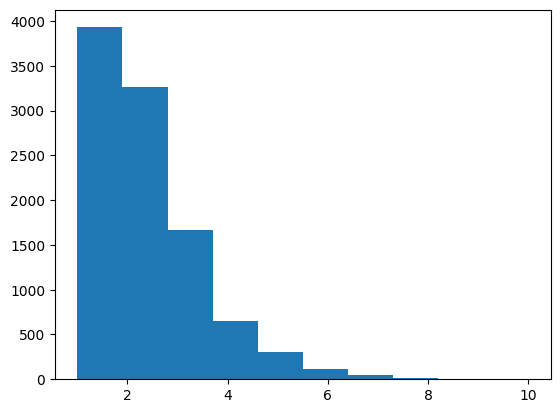

In [33]:
plt.hist(ds_result['reward']["magnitude"][:10000])

In [27]:
ds_result["reward"][0]

{'qid': 23156471,
 'question': '```\nweb_user_agents = {\n    "linux" => [\n            "Mozilla/5.0 (X11; U; Linux x86_64; en-US; rv:1.9.0.5) Gecko/2008122903 Gentoo Iceweasel/3.0.5",\n            "Opera/5.0 (Linux 2.0.38 i386; U) [en]",\n    ],\n    "windows" => [\n            "Mozilla/5.0 (Windows; U; Windows NT 5.0; en-US; rv:1.9.2a1pre) Gecko",\n            "Opera/9.63 (Windows NT 5.2; U; en) Presto/2.1.1",\n    ],\n}\n\n```\n\nHow can I iterate every element with key?\n\nThe output expected is:\n\n```\n"linux","Mozilla/5.0 (X11; U; Linux x86_64; en-US; rv:1.9.0.5) Gecko/2008122903 Gentoo Iceweasel/3.0.5"\n"linux","Opera/5.0 (Linux 2.0.38 i386; U) [en]"\n"windows","Mozilla/5.0 (Windows; U; Windows NT 5.0; en-US; rv:1.9.2a1pre) Gecko"\n"windows","Opera/9.63 (Windows NT 5.2; U; en) Presto/2.1.1",\n\n```',
 'answers': [{'answer_id': 23156826,
   'author': 'xlembouras',
   'author_id': 687142,
   'author_profile': 'https://Stackoverflow.com/users/687142',
   'pm_score': 2,
   'selecte

In [ ]:
ds_result = ds_result.remove_columns(["answers"])

In [ ]:
ds_result

DatasetDict({
    finetune: Dataset({
        features: ['qid', 'question', 'date', 'metadata', 'response_j', 'response_k'],
        num_rows: 7440923
    })
    reward: Dataset({
        features: ['qid', 'question', 'date', 'metadata', 'response_j', 'response_k'],
        num_rows: 7441998
    })
    rl: Dataset({
        features: ['qid', 'question', 'date', 'metadata', 'response_j', 'response_k'],
        num_rows: 7435908
    })
    evaluation: Dataset({
        features: ['qid', 'question', 'date', 'metadata', 'response_j', 'response_k'],
        num_rows: 4483004
    })
})

In [ ]:
for key in ds_result:
    print(key)

finetune
reward
rl
evaluation


In [ ]:
import os
import time
from multiprocessing import Pool
from tqdm import tqdm

from huggingface_hub import Repository


def save_shard(shard_tuple):
    """Save shard"""
    filename, shard = shard_tuple
    # use to_json instead to save as json file
    shard.to_parquet(filename)


def save_manual_shards(ds, user="lvwerra", remote_dataset_repo="stack-exchange-paired", subfolder="train"):
    """Save sharded data
    Args:
        ds (Dataset): dataset to be saved
        user (str): user name
        remote_dataset_repo (str): remote dataset repository
        out_path (str): path to save the shards"""
    # this will create a folder OUT_PATH that is a clone of REMOTE_DATASET_REPO
    # you can save the shards inside it and do git add/commit/push to push data to the hub
    out_path = remote_dataset_repo
    # if out path doesnt already exist
    if not os.path.exists(out_path):
        repo = Repository(
            local_dir=out_path,
            clone_from=user + "/" + remote_dataset_repo,
            repo_type="dataset",
            private=False,
            use_auth_token=True,
            git_user=user,
        )

    # files will be numerous we save them in a folder called data inside out_path
    if not os.path.exists(out_path):
        os.mkdir(out_path + "/data")
    os.mkdir(out_path + f"/data/{subfolder}")

    SHARD_SIZE = 1000 << 20
    if ds._indices is not None:
        dataset_nbytes = ds.data.nbytes * len(ds._indices) / len(ds.data)
    else:
        dataset_nbytes = ds.data.nbytes
    num_shards = int(dataset_nbytes / SHARD_SIZE) + 1
    print(f"Number of shards: {num_shards}")

    print("sharding the dataset")
    t_start = time.time()
    shards = (
        ds.shard(num_shards=num_shards, index=i, contiguous=True)
        for i in range(num_shards)
    )
    # use f"{OUT_PATH}/data/train-{index:05d}-of-{num_shards:05d}.json" instead for json files
    filenames = (
        f"{out_path}/data/{subfolder}/train-{index:05d}-of-{num_shards:05d}.parquet"
        for index in range(num_shards)
    )

    with Pool(16) as p:
        list(
            tqdm(
                p.imap_unordered(save_shard, zip(filenames, shards), chunksize=4),
                total=num_shards,
            )
        )
    print(f"Time to save dataset: {time.time()-t_start:.2f}")
    # to push dataset to hub do: git add/commit/push inside OUT_PATH

In [ ]:
for key in ds_result:
    save_manual_shards(ds_result[key], subfolder=key)

Number of shards: 20
sharding the dataset


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.43s/it]


Time to save dataset: 29.15
Number of shards: 20
sharding the dataset


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.15s/it]


Time to save dataset: 23.42
Number of shards: 20
sharding the dataset


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.83it/s]


Time to save dataset: 11.36
Number of shards: 12
sharding the dataset


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:10<00:00,  1.12it/s]


Time to save dataset: 11.13
